In [7]:

# plot trajectory of sessions with videos to get the fatsest sequence of runs in the TMrev20 and the slowest in the TM20 for illustration

vid120 = ['RatM22_2022_08_25_11_52_25', 
'RatM22_2022_08_25_12_12_38', 
'RatM22_2022_08_25_12_33_05', ]



# ----------------------------------------------------------------
## print sessions
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]
for animal in animalList:
        for session in sorted([os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Videos"+os.sep+"Rat*")]):
            if session not in allsession:
                print("'"+session+"', ")


'RatM22_2022_08_25_11_52_25', 
'RatM22_2022_08_25_12_12_38', 
'RatM22_2022_08_25_12_33_05', 


# Import all the libraries that we will need 

In [2]:
import copy
import csv
import dabest
import datetime
import fnmatch
import glob
from IPython.display import Image, display, clear_output
import itertools
from itertools import groupby
import matplotlib.cbook
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import re
import scipy
from scipy import stats
from scipy.ndimage import gaussian_filter as smooth
from scipy.signal import find_peaks
import statistics
import sys
import time
import warnings
matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()

# Define data path.

In [4]:
###Set the notebook screen ratio for jupyter
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:85% !important; }</style>"))

#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/DATA2022"
    savePath="/home/david/Desktop/Save"
else: #mac: if platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"#AET-2/test1203"#Desktop/DATARUN_ANALYSIS/test0826"#" #current : test0826
    savePath="/Users/tom/Desktop/Save"#os.path.join(root,"ALLRATS","Fig")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)#print("Notebook Path: ", notebookPath)
print("Save Path: ", savePath)   

Path to data is: /home/david/Desktop/DATA2022
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save


# Define functions

### LOAD DATA
#Data is loaded in one dictionary per variable (time, position, etc.) and have [animal, session] as keys, so we have a set of data for each session of each rat
#This cell loads all the behavioral data from the files created with labview
#data in .position is as follows (as of feb 2021): 
#[0:2]: Step of the experiment, e.g. "Session 1 ON". Takes 3 columns because of the spaces.
#[3]: Time at which the LV iteration has been done. Depends on the acquisition frequency, clock adds 0.04s at each iteration. 
#[4]: POSITION DATA : Position on the X axis (length of the treadmill) of the animal's centroid. This position is in pixels, it needs to be converted into cm using the datapxtocm function. The conversion (11px = 1cm) has been determined in LabView as a result of a calibration to counteract the lens distorsion generated with the camera.
#[5]: Same for the position on the Y axis. 
#[6]: LICK DATA : Left hand side of the treadmill. True/1 if there is a lick False/0 if not.
#[7]: Same but Right side
#[8]: SOLENOID DATA : Same idea as just above, Left Side, but determines if the valve has been opened (might be usefull in %to get reward protocol)
#[9]: Same but Right Side valve.
#[10]: BUFFER DATA : #ID of the frame that has been analyzed by LabView in this iteration, used to check if there is acquisition bugs, difference between two consecutive frames should be == 1.
#[11]: EDITED TRACKING : True/False or 1/0 that tells wether the frame has been edited in LabView. When the animal goes too far into the sides, or when the animal rears, the tracking loses the position of the animal and places the centroid precisely at the center of the tracking area. When this happens I coded LabView to maintain the position of the centroid in the last position in which the rat was detected and resume adequate tracking when available. TLDR, eliminates the jitter when tracking is not working properly. 

### LOAD PARAMETERS
#Parameters are loaded from behav_param file for each [animal, session] in a Dict
#sessionDuration : duration of the session 
#acqPer : number of acquisition per second in labview // not used anymore (acqPer -> delta between Time value of two consecutive frames)
#waterLeft : (weight of the measuring cup + 10 drops of water - weight of the cup) --> Weight of 10 drops on the Left, in grams. divide by 10 to have weight of a drop, multiply by 1000 to have value in µL  
#waterRight : idem on right  
#weight : Weight of each rat just before the session 
#lastWeightadlib : Weight of each rat when the water bottles are removed
#lastDayadlib : Last day with ad lib water
#daysSinceadlib : compute the number of days have elapsed since "lastDayadlib"
#boundaries : initialise the boundary array, that is computed later
#bloc duration data
#probability of getting reward on each side for eeach bloc
#treadmill speed for each block

In [8]:
%run VIGOR-Functions.py

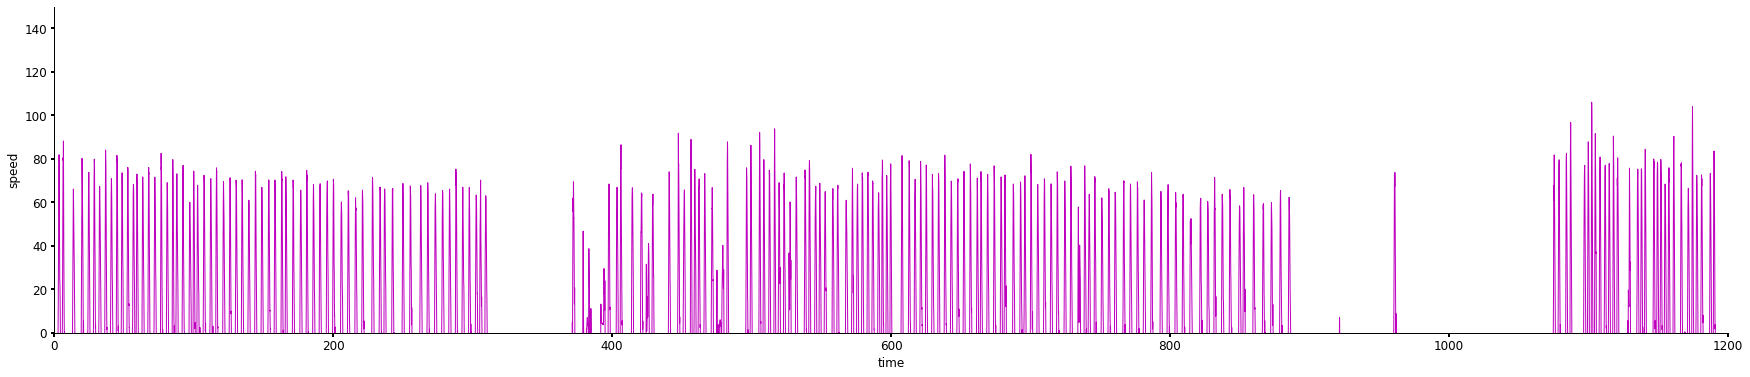

In [56]:
# plot the trajectory , remove tm speed from everything just to have an idea
# slowest runs between 800 and 900

def dirty_TRAJ(animal, session, params, barplotaxes,
                xyLabels=[" ", " ", " ", " "], title=[None], linewidth=[1]):

    ax1 = plt.gca()
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Videos"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    pos  = read_csv_pandas((root+os.sep+animal+os.sep+"Videos"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    edit  = read_csv_pandas((root+os.sep+animal+os.sep+"Videos"+os.sep + session + os.sep+session+".position"), Col=[-1])[:90000]


    # plt.scatter(time, edit*pos, label="edit", color="b", linewidth=1)

    pos, edit = fix_start_session(pos, edit)
    fixed= fixcamglitch(time, pos, edit)

    # plt.plot(time[:-1], (np.diff(pos)/0.25)+80, color='k', linewidth=linewidth[0])
    # plt.plot(time, pos, label="run", color="k", linewidth=1)

    # plt.plot(time, fixed, label="run", color="g", linewidth=2)
    # plt.plot(time[:-1], (np.diff(fixed)/0.25), color='g', linewidth=linewidth[0])


    # plt.plot(time, smooth(list(fixed), 2), label="run", color="m", linewidth=1)
    plt.plot(time[:-1], abs(smooth(list((np.diff(fixed)/0.04)), 2))-params, color='m', linewidth=linewidth[0])

    
    ax1.set_xlabel(xyLabels[0], fontsize=xyLabels[2])
    ax1.set_ylabel(xyLabels[1], fontsize=xyLabels[2])
    ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax1.set_ylim([barplotaxes[2], barplotaxes[3]])
    ax1.spines['bottom'].set_linewidth(linewidth[0])
    ax1.spines['left'].set_linewidth(linewidth[0])
    ax1.spines['top'].set_color("none")
    ax1.spines['right'].set_color("none")
    ax1.tick_params(width=2, labelsize=xyLabels[2])
    return ax1
animal = "RatM22"
session = matchsession(animal, vid120)[-1]

fig = plt.figure(figsize = (30, 6))
fig = dirty_TRAJ(animal, session, 20, [0, 1200, 0, 150], 
                 xyLabels=["time", "speed", 12, " "], title=[None], linewidth=[1])

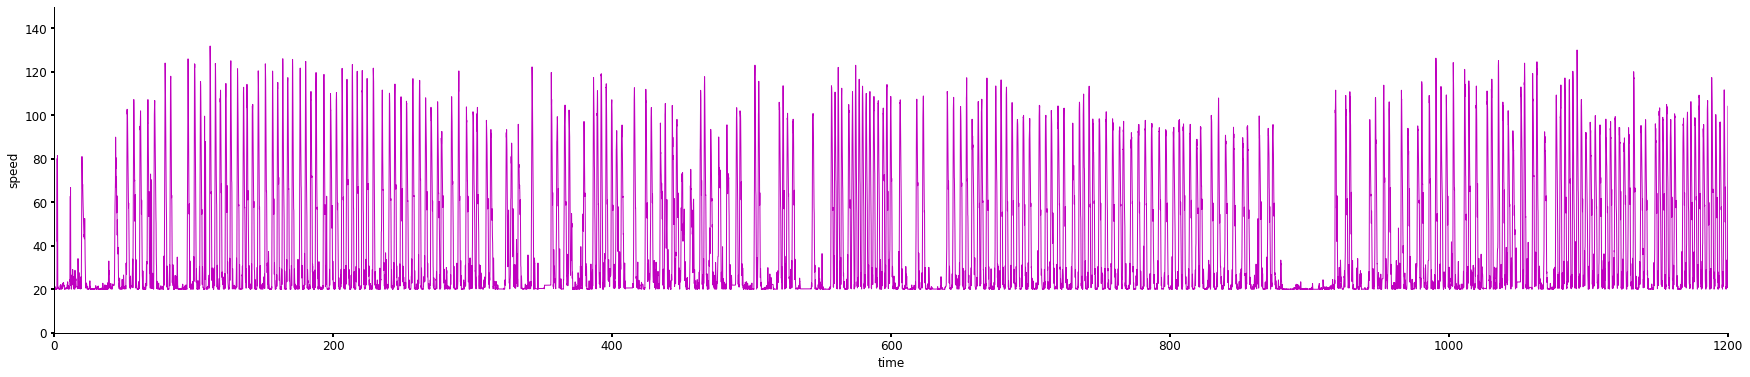

In [58]:
# fastest runs between 100 and 200
animal = "RatM22"
session = matchsession(animal, vid120)[0]
params={}
params[animal, session]     = get_from_pickle(root, animal, session, name="params.p")
fig = plt.figure(figsize = (30, 6))
fig = dirty_TRAJ(animal, session, -20, [0, 1200, 0, 150], 
                 xyLabels=["time", "speed", 12, " "], title=[None], linewidth=[1])